In [1]:
#4-6, notebook to import NISAR frames and RGI data, find NISAR frames w/ glaciers of interest (10km2 or larger)

In [8]:
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry
import fiona
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature


**Beginning section finds frames from a single nisar path that contain glaciers of interest**
- these steps take a kml file of a single track that was generated using ogr2ogr via command line
- 4/6 nighttime - not sure what happened, but maybe in compute reboot, no longer have libkml in my gdal so can't extract more track kmls from the overall kmz... workaround is at bottom of notebook, probably not the best way of doing it but seems to be working

<AxesSubplot:>

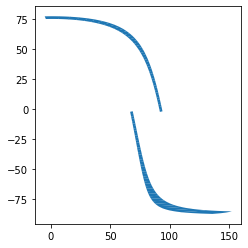

In [41]:
#reading in a kml for a single frame to see how it looks
#this is the kml file made from querying a spec path (98) in gdal cl
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
nisar_frame98 = gpd.read_file('/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/nisar_frames/T98A.kml', driver = 'KML')
nisar_frame98.plot()

In [10]:
def nisar_scenes_w_rgi_glaciers_single_track(rgi_path, nisar_df):
    '''this function takes a path to a dir containing rgi files (all rergions) and a 
    dataframe of nisar frames within a single track (defined earlier in notebook) 
    and returns a dataframe that contains only the frames containing rgi glaciers of 
    interest (currently over 10km2)
    '''
    
    #read in rgi shp files from directory containing files for all rgi regions 
    rgi_ls = os.listdir(rgi_path)
    #make dict where each key is region name, each value is the geo dataframe w/ rgi glaciers for that region
    rgi_region_key_ls = []
    rgi_region_val_ls = []
    for element in range(len(rgi_ls)):
        region_name = rgi_ls[element][:-8]
        if rgi_ls[element][-4:] == '.shp':
            rgi_region_key_ls.append(region_name)
            rgi_gpdf = gpd.read_file(f'/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km/{rgi_ls[element]}')
            rgi_region_val_ls.append(rgi_gpdf)
    rgi_dict = dict(zip(rgi_region_key_ls, rgi_region_val_ls))

    #because i read in rgi data for all glaciers larger than 1km2, make a new dict w/ same setup but only glaciers larger than 10km2
    rgi_10km_dict = {k:v.loc[v['Area'] >=10.] for (k,v) in rgi_dict.items()}
    #now, make dict into a single df for all regions
    rgi_df = pd.concat(list(rgi_10km_dict.values()), axis=0)

    #use spatial join to select nisar frames containing rgi glaciers 
    join_df = nisar_df.sjoin(rgi_df, how='inner')
    #make list of frame names (theres a row for every glacier so there will be repeat rows wrt nisar frame id)
    nisar_frames_ls = join_df['Description'].to_list()
    #find unique values in the list
    nisar_frames_uni = list(set(nisar_frames_ls))
    print(nisar_frames_uni)
    
    #now, want to go back to original nisar frame df and take only the rows with target glaciers
    nisar_df_sub = nisar_df[nisar_df['Name'].isin(nisar_frames_uni)]
    
    #plot to take a look
    fig, ax = plt.subplots()
    #plot selected nisar scenes
    nisar_df_sub.plot(ax=ax, color='blue')
    #plot all nisar scenes w/ low alpha
    nisar_df.plot(ax=ax, color='red', alpha=0.3)
    #plot glacier outlines
    rgi_df.plot(ax=ax, color='green')
    
    #return join_df
    return nisar_df_sub
    

In [14]:
rgi_path1 = '/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km'
nisar_path98 = '/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/nisar_frames/T98A.kml'

['L098_F015_AF', 'L098_F020_AF', 'L098_F043_AF', 'L098_F016_AF', 'L098_F018_AF', 'L098_F044_AF', 'L098_F019_AF', 'L098_F017_AF', 'L098_F023_AF']


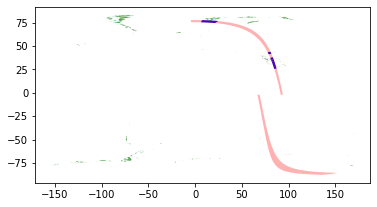

In [15]:
nisar_df98 = nisar_scenes_w_rgi_glaciers_from_path(rgi_path1, nisar_frame98)

In [16]:
nisar_df98

,Name,Description,geometry
14,L098_F015_AF,L098_F015_AF,"POLYGON ((87.10546 26.01420, 86.58286 25.88828..."
15,L098_F016_AF,L098_F016_AF,"POLYGON ((86.51128 28.00083, 85.97997 27.87250..."
16,L098_F017_AF,L098_F017_AF,"POLYGON ((85.89380 29.98624, 85.35286 29.85532..."
17,L098_F018_AF,L098_F018_AF,"POLYGON ((85.25042 31.97028, 84.69887 31.83657..."
18,L098_F019_AF,L098_F019_AF,"POLYGON ((84.57821 33.95280, 84.01499 33.81608..."
19,L098_F020_AF,L098_F020_AF,"POLYGON ((83.87378 35.93359, 83.29776 35.79363..."
22,L098_F023_AF,L098_F023_AF,"POLYGON ((81.52539 41.86333, 80.90324 41.71183..."
42,L098_F043_AF,L098_F043_AF,"POLYGON ((24.60155 76.58967, 23.82190 76.13354..."
43,L098_F044_AF,L098_F044_AF,"POLYGON ((17.01307 77.17338, 16.45766 76.69785..."


**now, trying to scale up to more tracks but can't use gdal ogr2ogr...** 
- solution: opened the full kmz in qgis, used batch vector layer saver to save every layer as its own shp file (in .../nisar_frames/frame_shps/), 
- making a dict (similar to rgi) with a key for each track and associated gpdf as the value for that key


In [68]:
#4/6 - 11 pm - figured out how to save/export each individual track as shp file from qgis so now triyng to work with that... 
nisar_shp_ls = os.listdir('/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/nisar_frames/frame_shps/Esri Shapefile')
print(len(nisar_shp_ls))

#make dict where each key is track name, each value is the geo dataframe w/ nisar scenes for that track 
nisar_frame_key_ls = []
nisar_frame_val_ls = []
for element in range(len(nisar_shp_ls)):
    cut_section = nisar_shp_ls[element][:19]
    #print(cut_section)
    frame_name_orig = nisar_shp_ls[element][19:]
    frame_name = frame_name_orig.replace(" ", "_")
    #print(frame_name)
    
    if frame_name[-4:] == '.shp':
        nisar_frame_key_ls.append(frame_name)
        nisar_frame_gpdf = gpd.read_file(f'/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/nisar_frames/frame_shps/Esri Shapefile/{nisar_shp_ls[element]}')
        nisar_frame_val_ls.append(nisar_frame_gpdf)
nisar_frame_dict = dict(zip(nisar_frame_key_ls, nisar_frame_val_ls))
print(len(nisar_frame_key_ls))



1557
346


In [70]:
#now, make dict into a single df for all tracks
nisar_df_full = pd.concat(list(nisar_frame_dict.values()), axis=0)
nisar_df_full.shape   

(30448, 19)

**next, want a function similar to the above function but it takes a df of all rgi glaciers and a df of all nisar scenes and returns nisar scenes containing glaciers of interest**

In [71]:
#first make rgi_df that will be input to new nf (same as above just out side the original function)
rgi_path_n =  '/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km'

#read in rgi shp files from directory containing files for all rgi regions 
rgi_ls = os.listdir(rgi_path_n)
#make dict where each key is region name, each value is the geo dataframe w/ rgi glaciers for that region
rgi_region_key_ls = []
rgi_region_val_ls = []
for element in range(len(rgi_ls)):
    region_name = rgi_ls[element][:-8]
    if rgi_ls[element][-4:] == '.shp':
        rgi_region_key_ls.append(region_name)
        rgi_gpdf = gpd.read_file(f'/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km/{rgi_ls[element]}')
        rgi_region_val_ls.append(rgi_gpdf)
rgi_dict = dict(zip(rgi_region_key_ls, rgi_region_val_ls))

#because read in rgi data for all glaciers larger than 1km2, make a new dict w/ same setup but only glaciers larger than 10km2
rgi_10km_dict = {k:v.loc[v['Area'] >=10.] for (k,v) in rgi_dict.items()} ## change the area value in this line to change threshold
#now, make dict into a single df for all regions
rgi_df = pd.concat(list(rgi_10km_dict.values()), axis=0)

In [72]:
def nisar_rgi_scene_seletion_alltracks(rgi_df, nisar_df): 
    
    #use spatial join to select nisar frames containing rgi glaciers 
    join_df = nisar_df.sjoin(rgi_df, how='inner')
    #make list of frame names (theres a row for every glacier so there will be repeat rows wrt nisar frame id)
    #print(join_df.columns)
    nisar_frames_ls = join_df['Name_left'].to_list()
    #find unique values in the list
    nisar_frames_uni = list(set(nisar_frames_ls))
    #print(nisar_frames_uni)
    
    #now, want to go back to original nisar frame df and take only the rows with target glaciers
    nisar_df_sub = nisar_df[nisar_df['Name'].isin(nisar_frames_uni)]
    
    #plot to take a look
    fig, ax = plt.subplots()
    #plot selected nisar scenes
    nisar_df_sub.plot(ax=ax, color='blue')
    #plot all nisar scenes w/ low alpha
    nisar_df.plot(ax=ax, color='red', alpha=0.05)
    #plot glacier outlines
    rgi_df.plot(ax=ax, color='green')
    
    #return join_df
    return nisar_df_sub
    

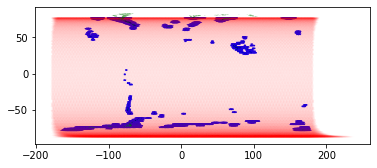

In [73]:
nisar_all_scenes_w_glaciers= nisar_rgi_scene_seletion_alltracks(rgi_df, nisar_df_full)

In [75]:
nisar_all_scenes_w_glaciers

,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,track,frame,pass,lookside,swath,mode,epsg,geometry
24,L005_F025_AF,L005_F025_AF,None,None,None,None,-1,0,1,None,None,5,25,Ascending,Left,Full,TBD,TBD,"POLYGON ((-117.97577 45.80316, -118.63616 45.6..."
26,L005_F027_AF,L005_F027_AF,None,None,None,None,-1,0,1,None,None,5,27,Ascending,Left,Full,TBD,TBD,"POLYGON ((-120.06378 49.72785, -120.77000 49.5..."
27,L005_F028_AF,L005_F028_AF,None,None,None,None,-1,0,1,None,None,5,28,Ascending,Left,Full,TBD,TBD,"POLYGON ((-121.23663 51.68312, -121.96897 51.5..."
29,L005_F030_AF,L005_F030_AF,None,None,None,None,-1,0,1,None,None,5,30,Ascending,Left,Full,TBD,TBD,"POLYGON ((-123.91558 55.57533, -124.70751 55.3..."
0,L135_F046_DF,L135_F046_DF,None,None,None,None,-1,0,1,None,None,135,46,Descending,Left,Full,TBD,TBD,"POLYGON ((151.37829 77.56273, 151.60098 77.073..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,L082_F124_DF,L082_F124_DF,None,None,None,None,-1,0,1,None,None,82,124,Descending,Left,Full,TBD,TBD,"POLYGON ((-71.64739 -70.38061, -70.19461 -70.5..."
79,L082_F125_DF,L082_F125_DF,None,None,None,None,-1,0,1,None,None,82,125,Descending,Left,Full,TBD,TBD,"POLYGON ((-73.38724 -72.40125, -71.78029 -72.5..."
30,L051_F031_AF,L051_F031_AF,None,None,None,None,-1,0,1,None,None,51,31,Ascending,Left,Full,TBD,TBD,"POLYGON ((165.86126 57.50978, 165.03568 57.304..."
66,L051_F155_AF,L051_F155_AF,None,None,None,None,-1,0,1,None,None,51,155,Ascending,Left,Full,TBD,TBD,"POLYGON ((172.24164 -45.91810, 171.53973 -46.0..."


In [76]:
# ^^ above object (nisar_all_scenes_w_glaciers) should be a dataframe of all nisar scenes that contain glaciers > 10km2
# looks like 1241 in total

**different size thresholds** </br>
glacier size cutoff: 10km2 -- # scenes containing glaciers: 1241 </br>
      glacier size: 20km2 -- # scenes: 1094 </br>
      glacier size: 50km2 -- # scenes: 866 </br>
      glacier size: 100km2 -- # scenes: 735

In [77]:
nisar_all_scenes_w_glaciers['pass'].value_counts()

Ascending     639
Descending    602
Name: pass, dtype: int64

In [78]:
nisar_all_scenes_w_glaciers['track'].value_counts()

169    18
11     16
5      15
97     14
106    14
       ..
64      2
67      2
148     2
94      2
76      1
Name: track, Length: 173, dtype: int64